# Analytical Work

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as scs
import helperfuns
from helperfuns import *
from numpy.lib.scimath import sqrt as csqrt
import matplotlib as mpl
import matplotlib.pyplot as plt
from helperfuns import *
from equilibriumfuns import *
fig_directory = '/Users/taliaborofsky/Documents/Stanford/Research/Feldman/Ecology_of_Learning/Pop Dynamics Social Learning/TeX_PopDyn/Figures_NoDelay'

# Number of Nonzero r equilibria

## For $R < \delta$

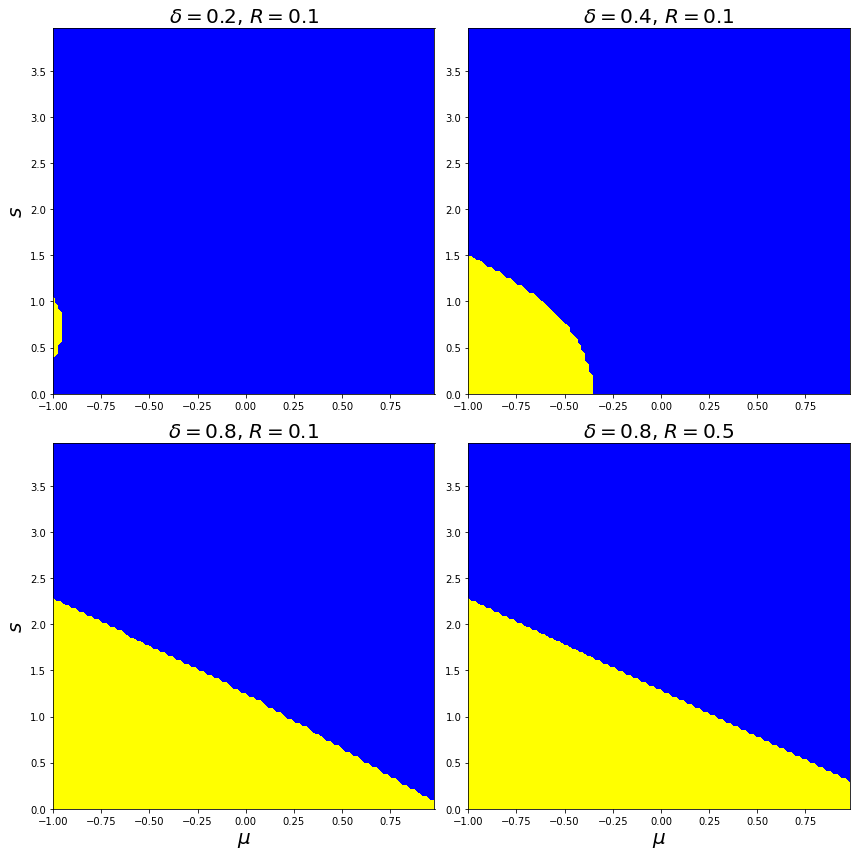

In [170]:
def separator(pc,K,delta,R):
    result = pc*(1-R)+(delta-R)*(1+R)*(2*K/(1+delta)-1)
    return(result)



muvals = np.arange(-1,1,0.02)
svals = np.arange(0,4,0.04)
mumesh,smesh = np.meshgrid(muvals,svals)

K = Kfun(smesh,scs.norm(mumesh))
pc = pcfun(smesh,scs.norm(mumesh))



fig, axes = plt.subplots(2,2,figsize = (12,12))
axs = axes.flatten()

deltas = [0.2,0.4,0.8,0.8]
Rs = [0.1,0.1,0.1,0.5]

for i in range(0,4):
    delta = deltas[i]
    R = Rs[i]
    ax = axs[i]
    cp = ax.contourf(mumesh,smesh, separator(pc,K,delta, R)>0, levels = [-0.5,0.5,1.5], colors = ['yellow','blue'])
    ax.set_title(r'$\delta =$%.1f, $R=$%.1f'%(delta,R), fontsize = 20)
    if i == 0 or i == 2:
        ax.set_ylabel(r'$s$',fontsize=20)
    if i>=2:
        ax.set_xlabel(r'$\mu$', fontsize = 20)
fig.tight_layout()
fig.savefig(fig_directory + '/Equilibria_RlessthanDelta.jpg',dpi=600)

## For $R > \delta$

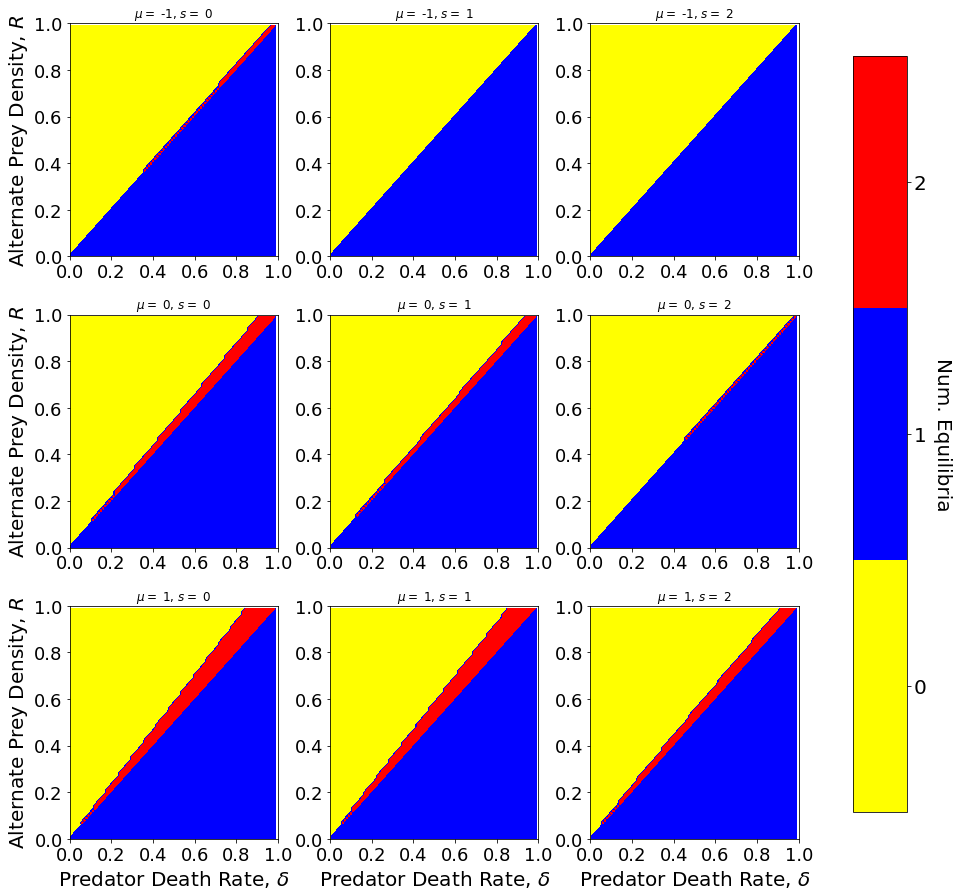

In [128]:
deltavals = np.arange(0,1,0.01)
Rvals = np.arange(0,1,0.01)

muvals = np.repeat([-1,0,1],3)
svals = np.tile([0,1,2],3)


# make parameter grid of delta and R

deltamesh, Rmesh = np.meshgrid(deltavals, Rvals)

# set up figure
fig, axes = plt.subplots(3,3, figsize = (15,15))

# vectorized functions
get_r_hat_vec = np.frompyfunc(get_r_hat,4,1)
numr = lambda r: sum(~np.isnan(r))
vnumr = np.vectorize(numr)

for i,ax in enumerate(axes.flatten()):
    mu = muvals[i]
    s = svals[i]
    K = Kfun(s,scs.norm(mu))
    pc = pcfun(s,scs.norm(mu))
    
    # for each (delta, R), find out the number of nonzero r hats. use np.isnan(). This is the contour

    out = get_r_hat_vec(K, pc, deltamesh, Rmesh)
    numr_mat = vnumr(out)

    # plot as contour plot
    cp = ax.contourf(deltamesh,Rmesh, numr_mat, levels = [-0.5,0.5,1.5,2.5], colors = ['yellow','blue','red'])

    # make ticks nice

    ax.set_xticks(ticks = np.arange(0,1.2,0.2))
    ax.set_yticks(ticks = np.arange(0,1.2,0.2))
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_title(r'$\mu=$ '+ str(mu) +r', $s = $ ' + str(s))
    # label axes
    if i in [6,7,8]:
        ax.set_xlabel(r'Predator Death Rate, $\delta$', fontsize=20)
    if i in [0,3,6]:
        ax.set_ylabel(r'Alternate Prey Density, $R$', fontsize=20)

# colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
cb = fig.colorbar(cp, cax = cbar_ax)
cb.ax.get_yaxis().set_ticks([0,1,2])
cb.ax.set_yticklabels([0,1,2], fontsize = 20)
cb.ax.set_ylabel(r'Num. Equilibria',rotation=-90, fontsize = 20, labelpad = 25)

fig.subplots_adjust(hspace=0.25,wspace = 0.25) # for if I have multiple plots


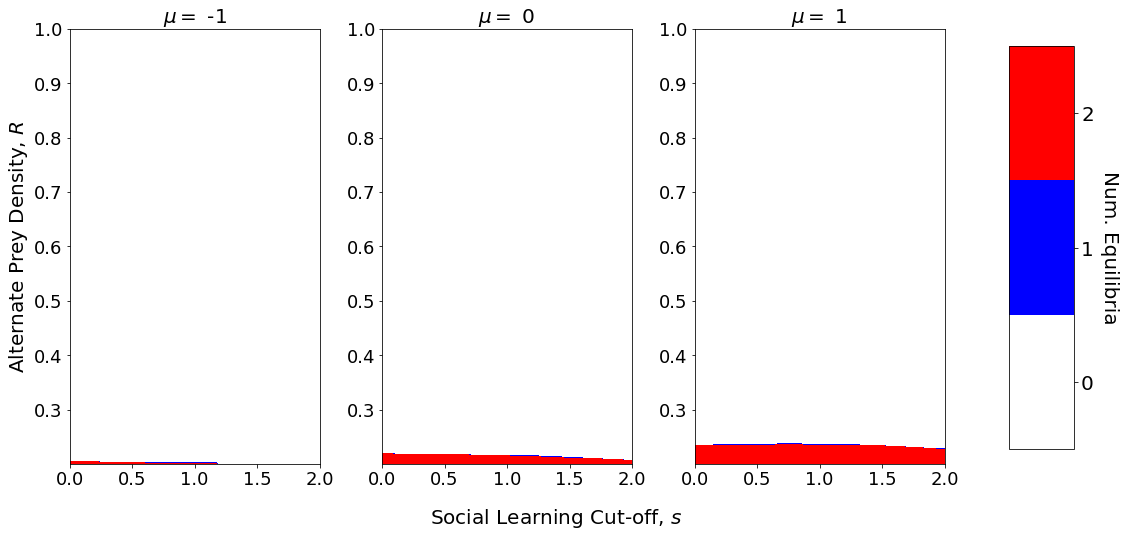

In [181]:
delta = 0.2
muvals = [-1,0,1]



Rvals = np.linspace(delta+0.001,1,500)
svals = np.linspace(0,2,100)




# make parameter grid of delta and R

smesh, Rmesh = np.meshgrid(svals, Rvals)

# set up figure
fig, axes = plt.subplots(1,3, figsize = (18,8))

# vectorized functions
get_r_hat_vec = np.frompyfunc(get_r_hat,4,1)
numr = lambda r: sum(~np.isnan(r))
vnumr = np.vectorize(numr)

for i,ax in enumerate(axes.flatten()):
    mu = muvals[i]
    
    K = Kfun(smesh,scs.norm(mu))
    pc = pcfun(smesh,scs.norm(mu))
    
    # for each (delta, R), find out the number of nonzero r hats. use np.isnan(). This is the contour

    out = get_r_hat_vec(K, pc, delta, Rmesh)
    numr_mat = vnumr(out)

    # plot as contour plot
    cp = ax.contourf(smesh,Rmesh, numr_mat, levels = [-0.5,0.5,1.5,2.5], colors = ['white','blue','red'])

    # make ticks nice

    #ax.set_xticks(ticks = np.arange(0,1.2,0.2))
    #ax.set_yticks(ticks = np.arange(0,1.2,0.2))
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_title(r'$\mu=$ '+ str(mu), fontsize = 20)

    if i in [0,3,6]:
        ax.set_ylabel(r'Alternate Prey Density, $R$', fontsize=20)

fig.supxlabel(r'Social Learning Cut-off, $s$', fontsize = 20)

        

# colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
cb = fig.colorbar(cp, cax = cbar_ax)
cb.ax.get_yaxis().set_ticks([0,1,2])
cb.ax.set_yticklabels([0,1,2], fontsize = 20)
cb.ax.set_ylabel(r'Num. Equilibria',rotation=-90, fontsize = 20, labelpad = 25)

fig.subplots_adjust(hspace=0.25,wspace = 0.25) # for if I have multiple plots
fig.savefig(fig_directory + '/NumEquilibria_Rversuss_delta02_big.eps')

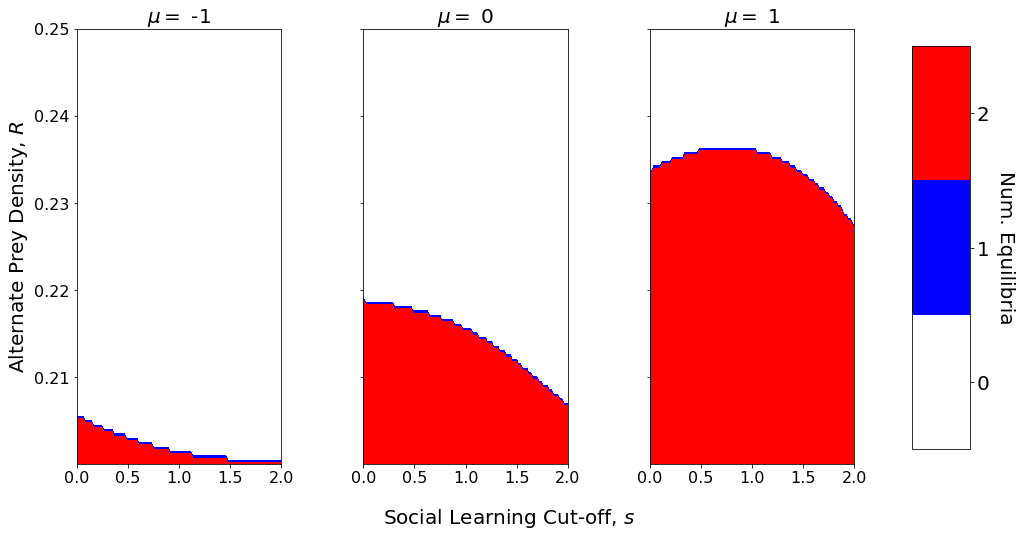

In [182]:
delta = 0.2
muvals = [-1,0,1]



Rvals = np.linspace(delta+0.0001,delta+0.05,100)
svals = np.linspace(0,2,100)




# make parameter grid of delta and R

smesh, Rmesh = np.meshgrid(svals, Rvals)

# set up figure
fig, axes = plt.subplots(1,3, figsize = (16,8),sharex=True, sharey=True)

# vectorized functions
get_r_hat_vec = np.frompyfunc(get_r_hat,4,1)
numr = lambda r: sum(~np.isnan(r))
vnumr = np.vectorize(numr)


for i,ax in enumerate(axes.flatten()):
    mu = muvals[i]
    
    K = Kfun(smesh,scs.norm(mu))
    pc = pcfun(smesh,scs.norm(mu))
    
    # for each (delta, R), find out the number of nonzero r hats. use np.isnan(). This is the contour

    out = get_r_hat_vec(K, pc, delta, Rmesh)
    numr_mat = vnumr(out)

    # plot as contour plot
    cp = ax.contourf(smesh,Rmesh, numr_mat, levels = [-0.5,0.5,1.5,2.5], colors = ['white','blue','red'])

    # make ticks nice

    #ax.set_xticks(ticks = np.arange(0,1.2,0.2))
    #ax.set_yticks(ticks = np.arange(0,1.2,0.2))
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_title(r'$\mu=$ '+ str(mu), fontsize = 20)
    # label axes
    
    #ax.set_xlabel(r'Social Learning Cut-off, $s$', fontsize=20, labelpad = 15)
    if i == 0:
        ax.set_ylabel(r'Alternate Prey Density, $R$', fontsize=20)
    #ax.get_xaxis().labelpad=15

    
fig.supxlabel(r'Social Learning Cut-off, $s$', fontsize = 20)


# colorbar

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
cb = fig.colorbar(cp, cax = cbar_ax)
cb.ax.get_yaxis().set_ticks([0,1,2])
cb.ax.set_yticklabels([0,1,2], fontsize = 20)
cb.ax.set_ylabel(r'Num. Equilibria',rotation=-90, fontsize = 20, labelpad = 25)

fig.subplots_adjust(hspace=0.25,wspace = 0.4) # for if I have multiple plots

fig.savefig(fig_directory + '/NumEquilibria_Rversuss_delta02_close.eps')

In [79]:
f = np.vectorize(complex)
[1,f(1,2),2]

[1, array(1.+2.j), 2]

In [6]:
delta = 0.3
R = 0.7
K = 0
pc = 1
Q_r_delta = delta*(delta-R)*((K/(1+delta))*(delta+R) + pc - (1+R)*(1-K/(1+delta)))

In [7]:
get_r_hat(K,pc,delta,R)

[0, 0]

In [15]:
mu = np.array([-1,0,1])
s = np.append(np.linspace(0,1,5),[2,3])
delta = 0.2
R = [0.21, 0.3, 0.5, 0.8]

mu_mat, s_mat, delta_mat, R_mat = np.meshgrid(mu, s, delta, R)
mu_vec, s_vec, delta_vec, R_vec = [np.ndarray.flatten(vec) for vec in [mu_mat, s_mat, delta_mat, R_mat]]
norms = scs.norm(mu_vec)
K = Kfun(s_vec,norms)
pc = pcfun(s_vec,norms)

TypeError: oct() takes exactly one argument (2 given)

In [134]:
rhat1, rhat2 = get_r_hat_v(K, pc, delta_vec, R_vec)

In [39]:
get_r_hat_vec = np.frompyfunc(get_r_hat,4,1)

In [40]:
get_r_hat_vec

<ufunc 'get_r_hat (vectorized)'>

In [41]:
out = get_r_hat_vec(K, pc, delta_vec, R_vec)

In [168]:
df = pd.DataFrame(data={'K':K, 'pc':pc, 'mu': mu_vec, 's': s_vec, 'delta':delta_vec, 
                        'R': R_vec, 'rhat_1':rhat1, 'rhat_2':rhat2})

In [147]:
mu = 0; s = 0.5; delta = 0.2




In [181]:
np.vectorize(get_internal_stability)(rhat1,beta,K,pc,delta,R) 

ZeroDivisionError: float division by zero

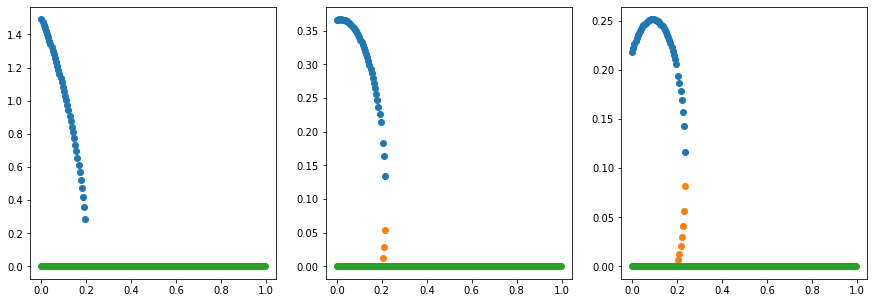

In [22]:
fig,axs= plt.subplots(1,3, figsize=(15,5) )
mu = -1
s = 0.5
delta = 0.2
R = np.arange(0,1,0.005)
for i, ax in enumerate(axs):
    K = Kfun(s,scs.norm(mu))
    pc = pcfun(s,scs.norm(mu))
    rhat1, rhat2 = get_r_hat_v(K,pc,delta,R)
    rhat1[rhat1==0]=np.nan
    rhat2[rhat2==0]=np.nan
    rhat3 = np.zeros(rhat1.shape)
    #stability1 = np.vectorize(get_internal_stability)(rhat1,beta,K,pc,delta,R)
    #stability2 = get_internal_stability(rhat2,beta,K,pc,delta,R)
    #stability3 = get_internal_stability(rhat2,beta,K,pc,delta,R)
    ax.scatter(R,rhat1)
    ax.scatter(R,rhat2)
    ax.scatter(R,rhat3)
    mu = mu + 1

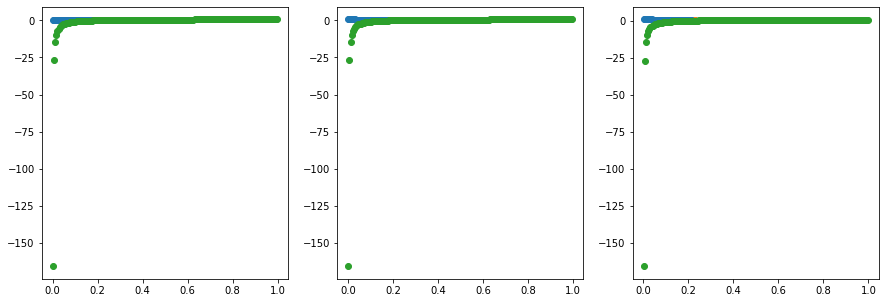

In [171]:
fig,axs= plt.subplots(1,3, figsize=(15,5) )
mu = -1
s = 0.5
delta = 0.2
R = np.arange(0.001,1,0.005)
for i, ax in enumerate(axs):
    K = Kfun(s,scs.norm(mu))
    pc = pcfun(s,scs.norm(mu))
    rhat1, rhat2 = get_r_hat_v(K,pc,delta,R)
    rhat1[rhat1==0]=np.nan
    rhat2[rhat2==0]=np.nan
    uhat1 = np.vectorize(get_u_hat)(rhat1,delta,R)
    uhat2 = np.vectorize(get_u_hat)(rhat2,delta,R)
    #uhat3 = np.vectorize(get_u_hat)(0,delta,R)
    
    #stability1 = get_internal_stability(rhat1,beta,K,pc,delta,R)
    #stability2 = get_internal_stability(rhat2,beta,K,pc,delta,R)
    #stability3 = get_internal_stability(rhat2,beta,K,pc,delta,R)
    ax.scatter(R,uhat1)
    ax.scatter(R,uhat2)
    mu = mu + 1

# Social Learning and Population Size of Nonzero r equilibria

In [179]:
def get_r_hat_1(K,pc,delta,R):
    # for R < delta
    
    a = pc + K*(delta-R)/(1+delta)
    b = (delta-R)*(K*(1+R)/(1+delta)-1) - R*pc
    c = -R*(delta-R)*(1 - K/(1+delta))
    
    # check if there's an equilibrium
    Q_r_1 = pc*(1-R) + (delta-R)*(1+R)*(2*K/(1+delta)-1)
    if Q_r_1 >=0:
        rpos = (-b + np.sqrt(b**2 - 4*a*c))/(2*a) 
        return(rpos)
    else:
        return(np.nan)

## $R=0.2,\delta=0.3$

In [210]:
R = 0.2
delta = 0.3
mu = 0
beta = 0.05

svec = np.arange(0,3.05,0.05)
Kvec = Kfun(svec,scs.norm(mu))
pcvec = pcfun(svec,scs.norm(mu))

get_r_hat_vec = np.frompyfunc(get_r_hat_1,4,1)
r_equilibria = get_r_hat_vec(Kvec,pcvec,delta,R)
N_equilibria1 = get_N_hat(r_equilibria,delta,R,beta)

# now mu = -1
mu = -0.5
Kvec = Kfun(svec,scs.norm(mu))
pcvec = pcfun(svec,scs.norm(mu))


r = get_r_hat_vec(Kvec,pcvec,delta,R) # this is a problem because i'm getting r values greater than 1
N_equilibria2 = (1-r)*(r-R)/(beta*(delta-R))


beta = 0.02
N_equilibria3 = get_N_hat(r_equilibria,delta,R,beta)
N_equilibria4 = (1-r)*(r-R)/(beta*(delta-R))




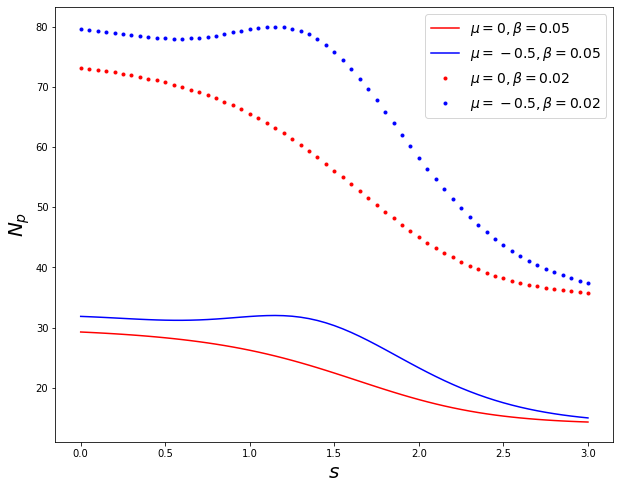

In [211]:
fig,ax = plt.subplots(1,1,figsize=(10,8))

# larger beta
ax.plot(svec,N_equilibria1, 'r', label = r'$\mu=0,\beta=0.05$') # mu = 0
ax.plot(svec,N_equilibria2,'b',label = r'$\mu=-0.5,\beta=0.05$') # mu = -0.5
# small beta
ax.plot(svec,N_equilibria3, '.r',label = r'$\mu=0,\beta=0.02$') # mu = 0
ax.plot(svec,N_equilibria4,'.b',label = r'$\mu=-0.5,\beta=0.02$') # mu = -0.5
ax.legend(fontsize=14)
ax.set_xlabel(r'$s$', fontsize = 20)
ax.set_ylabel(r'$N_p$', fontsize = 20)

fig.savefig(fig_directory + '/N_vs_s_R2delta3.jpg',dpi=600)

## $R=0.1,\delta=0.3$

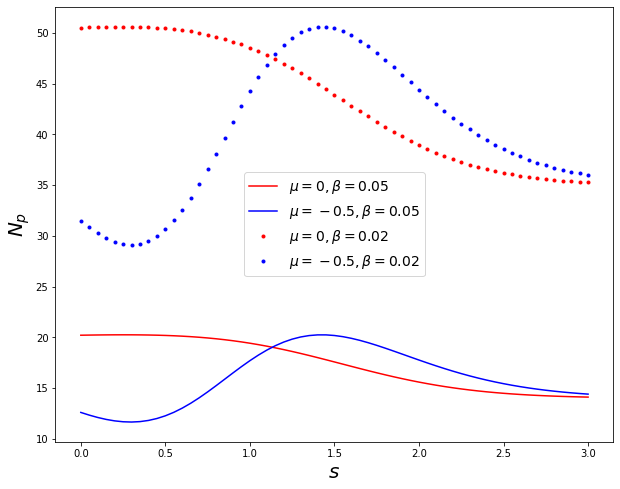

In [212]:
R = 0.1
delta = 0.3
mu = 0
beta = 0.05

svec = np.arange(0,3.05,0.05)
Kvec = Kfun(svec,scs.norm(mu))
pcvec = pcfun(svec,scs.norm(mu))

get_r_hat_vec = np.frompyfunc(get_r_hat_1,4,1)
r_equilibria = get_r_hat_vec(Kvec,pcvec,delta,R)
N_equilibria1 = get_N_hat(r_equilibria,delta,R,beta)


mu = -0.5
Kvec = Kfun(svec,scs.norm(mu))
pcvec = pcfun(svec,scs.norm(mu))


r = get_r_hat_vec(Kvec,pcvec,delta,R) # this is a problem because i'm getting r values greater than 1
N_equilibria2 = (1-r)*(r-R)/(beta*(delta-R))


beta = 0.02
N_equilibria3 = get_N_hat(r_equilibria,delta,R,beta)
N_equilibria4 = (1-r)*(r-R)/(beta*(delta-R))


fig,ax = plt.subplots(1,1,figsize=(10,8))

# larger beta
ax.plot(svec,N_equilibria1, 'r', label = r'$\mu=0,\beta=0.05$') # mu = 0
ax.plot(svec,N_equilibria2,'b',label = r'$\mu=-0.5,\beta=0.05$') # mu = -0.5
# small beta
ax.plot(svec,N_equilibria3, '.r',label = r'$\mu=0,\beta=0.02$') # mu = 0
ax.plot(svec,N_equilibria4,'.b',label = r'$\mu=-0.5,\beta=0.02$') # mu = -0.5
ax.legend(fontsize=14)
ax.set_xlabel(r'$s$', fontsize = 20)
ax.set_ylabel(r'$N_p$', fontsize = 20)
fig.savefig(fig_directory + '/N_vs_s_R1delta3.jpg',dpi=600)


# Optimal s

In [276]:
R = 0.1
delta = 0.3
mu = 0
beta = 0.05

def replace_NA(numpyvec):
    numpyvec[np.isnan(numpyvec)]=0
    return(numpyvec)
def get_optimal_s(mu,R,delta,beta):
    svec = np.arange(0,4,0.001)

    Kvec = Kfun(svec,scs.norm(mu))
    pcvec = pcfun(svec,scs.norm(mu))
    r = np.array(get_r_hat_vec(Kvec,pcvec,delta,R),dtype=float) # this is a problem because i'm getting r values greater than 1
    N_equilibria = (1-r)*(r-R)/(beta*(delta-R))


    max_index = np.argmax(replace_NA(N_equilibria))
    N_max = N_equilibria[max_index]
    s_max = svec[max_index]
    return(s_max,N_max)

In [281]:
betavals = np.linspace(0.001,0.1,100)
muvals = np.linspace(-1,1,200)

R = 0.2
delta = 0.5

mu = -0.5
#mumesh, betamesh = np.meshgrid(muvals,betavals)

get_optimal_s_vec = np.frompyfunc(get_optimal_s,4,2)


s_maxes, N_maxes = get_optimal_s_vec(muvals,R,delta,0.05)
s_maxes1 = np.array(s_maxes,dtype=float)

R = 0.4; delta = 0.5;
s_maxes, N_maxes = get_optimal_s_vec(muvals,R,delta,0.05)
s_maxes2 = np.array(s_maxes,dtype=float)

R = 0.1; delta = 0.2;
s_maxes, N_maxes = get_optimal_s_vec(muvals,R,delta,0.05)
s_maxes3 = np.array(s_maxes,dtype=float)

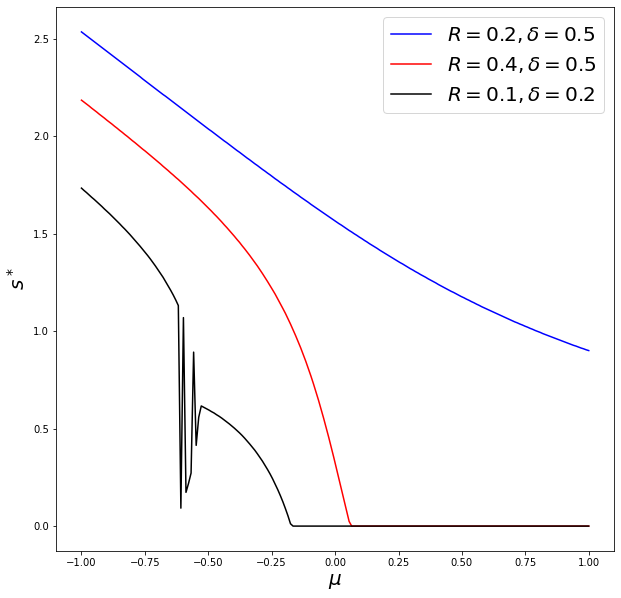

In [282]:
fig,ax = plt.subplots(1,1,figsize=(10,10))



ax.plot(muvals,s_maxes1,'b', label = r'$R=0.2, \delta=0.5$') # R = 0.2, delta = 0.5


ax.plot(muvals,s_maxes2,'r',label=r'$R=0.4, \delta=0.5$')


ax.plot(muvals,s_maxes3,'k',label=r'$R=0.1, \delta=0.2$')


ax.set_xlabel(r'$\mu$', fontsize=20)
ax.set_ylabel(r'$s^*$', fontsize=20)
ax.legend(fontsize=20)
#plt.contour(mumesh,betamesh,s_maxes)

In [279]:
s_maxes

array([1.733, 1.721, 1.71 , 1.698, 1.686, 1.675, 1.663, 1.651, 1.639,
       1.626, 1.614, 1.602, 1.589, 1.576, 1.563, 1.55 , 1.536, 1.523,
       1.509, 1.495, 1.48 , 1.465, 1.45 , 1.435, 1.419, 1.403, 1.387,
       1.37 , 1.352, 1.334, 1.315, 1.296, 1.276, 1.254, 1.232, 1.209,
       1.185, 1.159, 1.131, 0.092, 1.069, 0.173, 0.219, 0.272, 0.892,
       0.414, 0.558, 0.616, 0.609, 0.602, 0.595, 0.587, 0.58 , 0.571,
       0.563, 0.554, 0.544, 0.534, 0.524, 0.513, 0.502, 0.49 , 0.478,
       0.465, 0.451, 0.436, 0.421, 0.405, 0.389, 0.371, 0.352, 0.333,
       0.312, 0.29 , 0.267, 0.242, 0.215, 0.187, 0.157, 0.125, 0.09 ,
       0.053, 0.012, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   ,

$\beta$ has no effect???? I have to prove this in some way

In [233]:
get_optimal_s(,0.1,0.3,0.05)

(0.0, 17.924828844460656)

Maybe I should find the s that maximizes N?

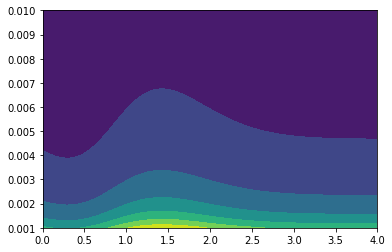

In [202]:
betavals = np.linspace(0.001,0.01,100)
svals = np.linspace(0,4,100)

R = 0.1
delta = 0.3

mu = -0.5
smesh,betamesh = np.meshgrid(svals,betavals)

# to find r
get_r_hat_vec = np.frompyfunc(get_r_hat_1,4,1)

# K and pc
K = Kfun(smesh,scs.norm(mu))
pc = pcfun(smesh,scs.norm(mu))

r_out = get_r_hat_vec(K,pc,delta,R)
r = np.array(r_out,dtype=float)
N = (1-r)*(r-R)/(betamesh*(delta-R))

plt.contourf(smesh,betamesh,N)

In [189]:
N

array([[73.13708499, 73.0047417 , 72.8638361 , ..., 35.02424442,
        35.02048834, 35.01728709],
       [73.13708499, 73.0047417 , 72.8638361 , ..., 35.02424442,
        35.02048834, 35.01728709],
       [73.13708499, 73.0047417 , 72.8638361 , ..., 35.02424442,
        35.02048834, 35.01728709],
       ...,
       [73.13708499, 73.0047417 , 72.8638361 , ..., 35.02424442,
        35.02048834, 35.01728709],
       [73.13708499, 73.0047417 , 72.8638361 , ..., 35.02424442,
        35.02048834, 35.01728709],
       [73.13708499, 73.0047417 , 72.8638361 , ..., 35.02424442,
        35.02048834, 35.01728709]])

In [188]:
K

array([[0.        , 0.03222899, 0.06440542, ..., 0.99991115, 0.99992492,
        0.99993666],
       [0.        , 0.03222899, 0.06440542, ..., 0.99991115, 0.99992492,
        0.99993666],
       [0.        , 0.03222899, 0.06440542, ..., 0.99991115, 0.99992492,
        0.99993666],
       ...,
       [0.        , 0.03222899, 0.06440542, ..., 0.99991115, 0.99992492,
        0.99993666],
       [0.        , 0.03222899, 0.06440542, ..., 0.99991115, 0.99992492,
        0.99993666],
       [0.        , 0.03222899, 0.06440542, ..., 0.99991115, 0.99992492,
        0.99993666]])